In [2]:
from xgboost import XGBClassifier

In [1]:
from sklearn.metrics import log_loss,make_scorer
from sklearn.model_selection import StratifiedKFold,RepeatedKFold,RepeatedStratifiedKFold,KFold,GridSearchCV,RandomizedSearchCV,train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge,LogisticRegressionCV
from sklearn.decomposition import PCA

from matplotlib.colors import ListedColormap

import Traitement as proc
import Predicteurs as cl
import Model_selection as ms
import pandas as pd
import pickle
import os
import imp

import matplotlib.pyplot as plt
import numpy as np

In [25]:
proc = imp.reload(proc)

In [3]:
base = 'epilung'

In [4]:
nmois = 12

In [5]:
id = 1

In [6]:
cv_primary = StratifiedKFold(n_splits=5)

In [7]:
classifieur_fr = cl.LinearClassifieur(LogisticRegression(penalty='l1'),nmois,cv_primary)

In [8]:
classifieur_fs = cl.LinearClassifieur(LogisticRegression(solver = 'newton-cg'),nmois,cv_primary)

In [9]:
C_grid = np.logspace(-1,1.5,num=100)

In [10]:
cv_model = RepeatedStratifiedKFold(n_splits=5,n_repeats=10)

In [11]:
scoring_model = make_scorer(log_loss,greater_is_better=False,needs_proba=True,labels=[0,1])

In [12]:
classifieur_model = LogisticRegressionCV(C_grid,cv=cv_model,n_jobs=-1,scoring='neg_log_loss',solver='liblinear',refit=False)

In [36]:
XGB = XGBClassifier(n_jobs=-1)

In [13]:
classifieur_model2 = GridSearchCV(LogisticRegression(),{"C":C_grid},scoring=scoring_model,n_jobs=-1,cv=cv_model,return_train_score=False)

In [17]:
cv_i = 1

In [58]:
taille_maille = 0.2

In [19]:
std = True

In [20]:
Index_fs = proc.import_index_fs(base,id,cv_primary,classifieur_fr,classifieur_fs,nmois=nmois,std=std)

In [21]:
Index_cv = proc.import_index_cv(base,id,cv_primary,nmois,std)

In [22]:
X = proc.import_X(base=base,nmois=nmois,std=std)
Y = proc.import_Y(base,nmois)

In [23]:
IndexVal,IndexTest = ms.get_test_train_indexes(Index_cv,cv_i)
Indexfs = Index_fs.loc[Index_fs[cv_i]].index

In [24]:
X_fs = X.loc[:,Indexfs]

In [400]:
ACP = PCA(n_components=5)

In [401]:
ACP.fit(X_fs)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [402]:
n = ACP.n_components_

In [403]:
X_val = X_fs.loc[IndexVal]
Y_val = Y.loc[IndexVal]

In [404]:
X_test = X_fs.loc[IndexTest]
Y_test = Y.loc[IndexTest]

In [405]:
X_valr = ACP.transform(X_val)
X_testr = ACP.transform(X_test)

In [293]:
x_min = min(X_valr[:,1].min(), X_testr[:,1].min()) - .5
x_max = max(X_valr[:,1].max(), X_testr[:,1].max()) + .5
    
y_min = min(X_valr[:,2].min(), X_testr[:,2].min()) - .5
y_max = max(X_valr[:,2].max(), X_testr[:,2].max()) + .5

In [406]:
index_min = [X_valr[:,i].min()-.5 for i in range(n)]
index_max = [X_valr[:,i].max()+.5 for i in range(n)]

In [34]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [467]:
grid = np.meshgrid(*[[coef] if k not in [i,j] else np.arange(index_min[k],index_max[k],taille_maille) for k in range(n)])

In [468]:
grid[0].shape

(99, 1, 109, 1, 1)

In [378]:
zz.shape

(99, 1, 116)

In [379]:
yy.shape

(99, 1, 116)

In [380]:
xx.shape

(99, 1, 116)

In [ ]:
index_min = [X_valr[:,i].min()-.5 for i in range(n)]
index_max = [X_valr[:,i].max()+.5 for i in range(n)]

In [433]:
a = np.c_[tuple(g.ravel() for g in grid)]

b = ACP.inverse_transform(a)

df = pd.DataFrame(b,columns=X_val.columns)

In [438]:
Z = XGB.predict_proba(df)[:,1]

In [439]:
Z.shape

(10791,)

In [440]:
Z = Z.reshape(grid[0].shape)

In [446]:
Z.shape

(99, 1, 109, 1, 1)

In [458]:
np.s_[:,:,0]

(slice(None, None, None), slice(None, None, None), 0)

In [456]:
slice(None)

slice(None, None, None)

In [457]:
slice(0)

slice(None, 0, None)

In [469]:
shape = grid[0].shape

In [471]:
s = tuple(slice(None) if shape[k] !=1 else 0 for k in range(n))

In [472]:
s

(slice(None, None, None), 0, slice(None, None, None), 0, 0)

In [473]:
Z[s].shape

(99, 109)

In [515]:
coef = 20

In [525]:
def plotij(i,j,axe,**kwargs):
    
    marker_size = kwargs.get('marker_size',None)
    
    grid = np.meshgrid(*[[coef] if k not in [i,j] else np.arange(index_min[k],index_max[k],taille_maille) for k in range(n)])
        
    a = np.c_[tuple(g.ravel() for g in grid)]
    b = ACP.inverse_transform(a)
    df = pd.DataFrame(b,columns=X_val.columns)

    XGB.fit(X_val,Y_val)
    Z = XGB.predict_proba(df)[:,1]
    Z = Z.reshape(grid[0].shape)

    shape = grid[0].shape
    s = tuple(slice(None) if shape[k] !=1 else 0 for k in range(n))
        
    ax.contourf(grid[i][s],grid[j][s],Z[s],cmap=cm,alpha=.8)
        
    ax.scatter(X_valr[:,i],X_valr[:,j],c=Y_val,cmap=cm_bright,edgecolors='k',s=marker_size)
    ax.scatter(X_testr[:,i],X_testr[:,j],c=Y_test,cmap=cm_bright,edgecolors='k',alpha=0.6,s=marker_size)
    
    ax.set_xlim(grid[i].min(),grid[i].max())
    ax.set_ylim(grid[j].min(),grid[j].max())
        
    ax.set_xticks(())
    ax.set_yticks(())

In [542]:
coef = 10

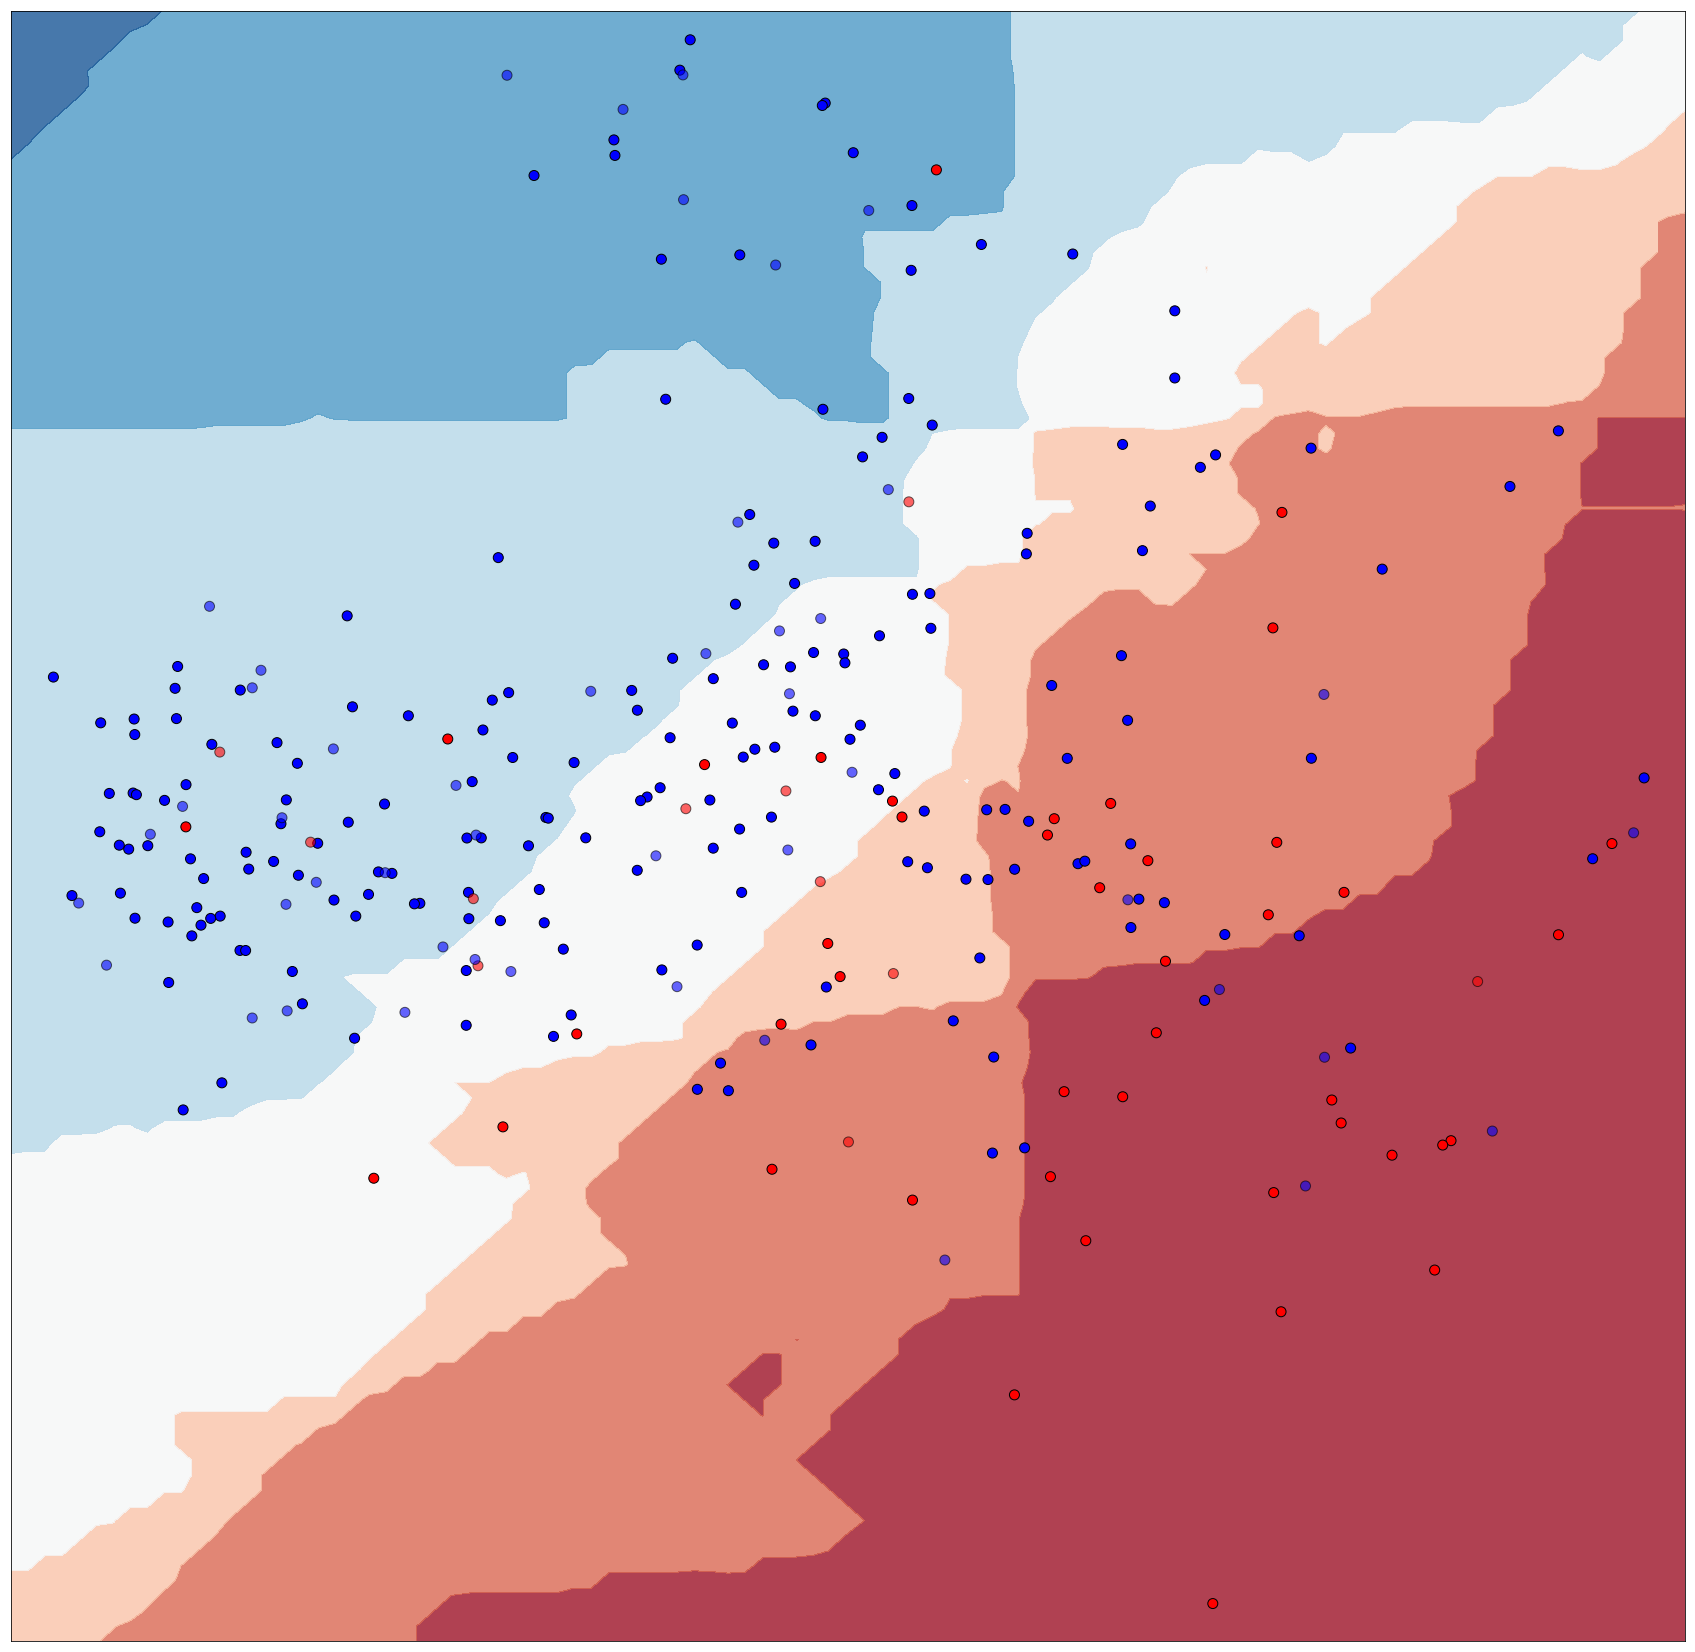

In [543]:
fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)

plotij(1,2,ax,marker_size=100)

#plt.savefig('scatterplot.png',bbox_inches='tight')
plt.show()

In [566]:
coef = 9

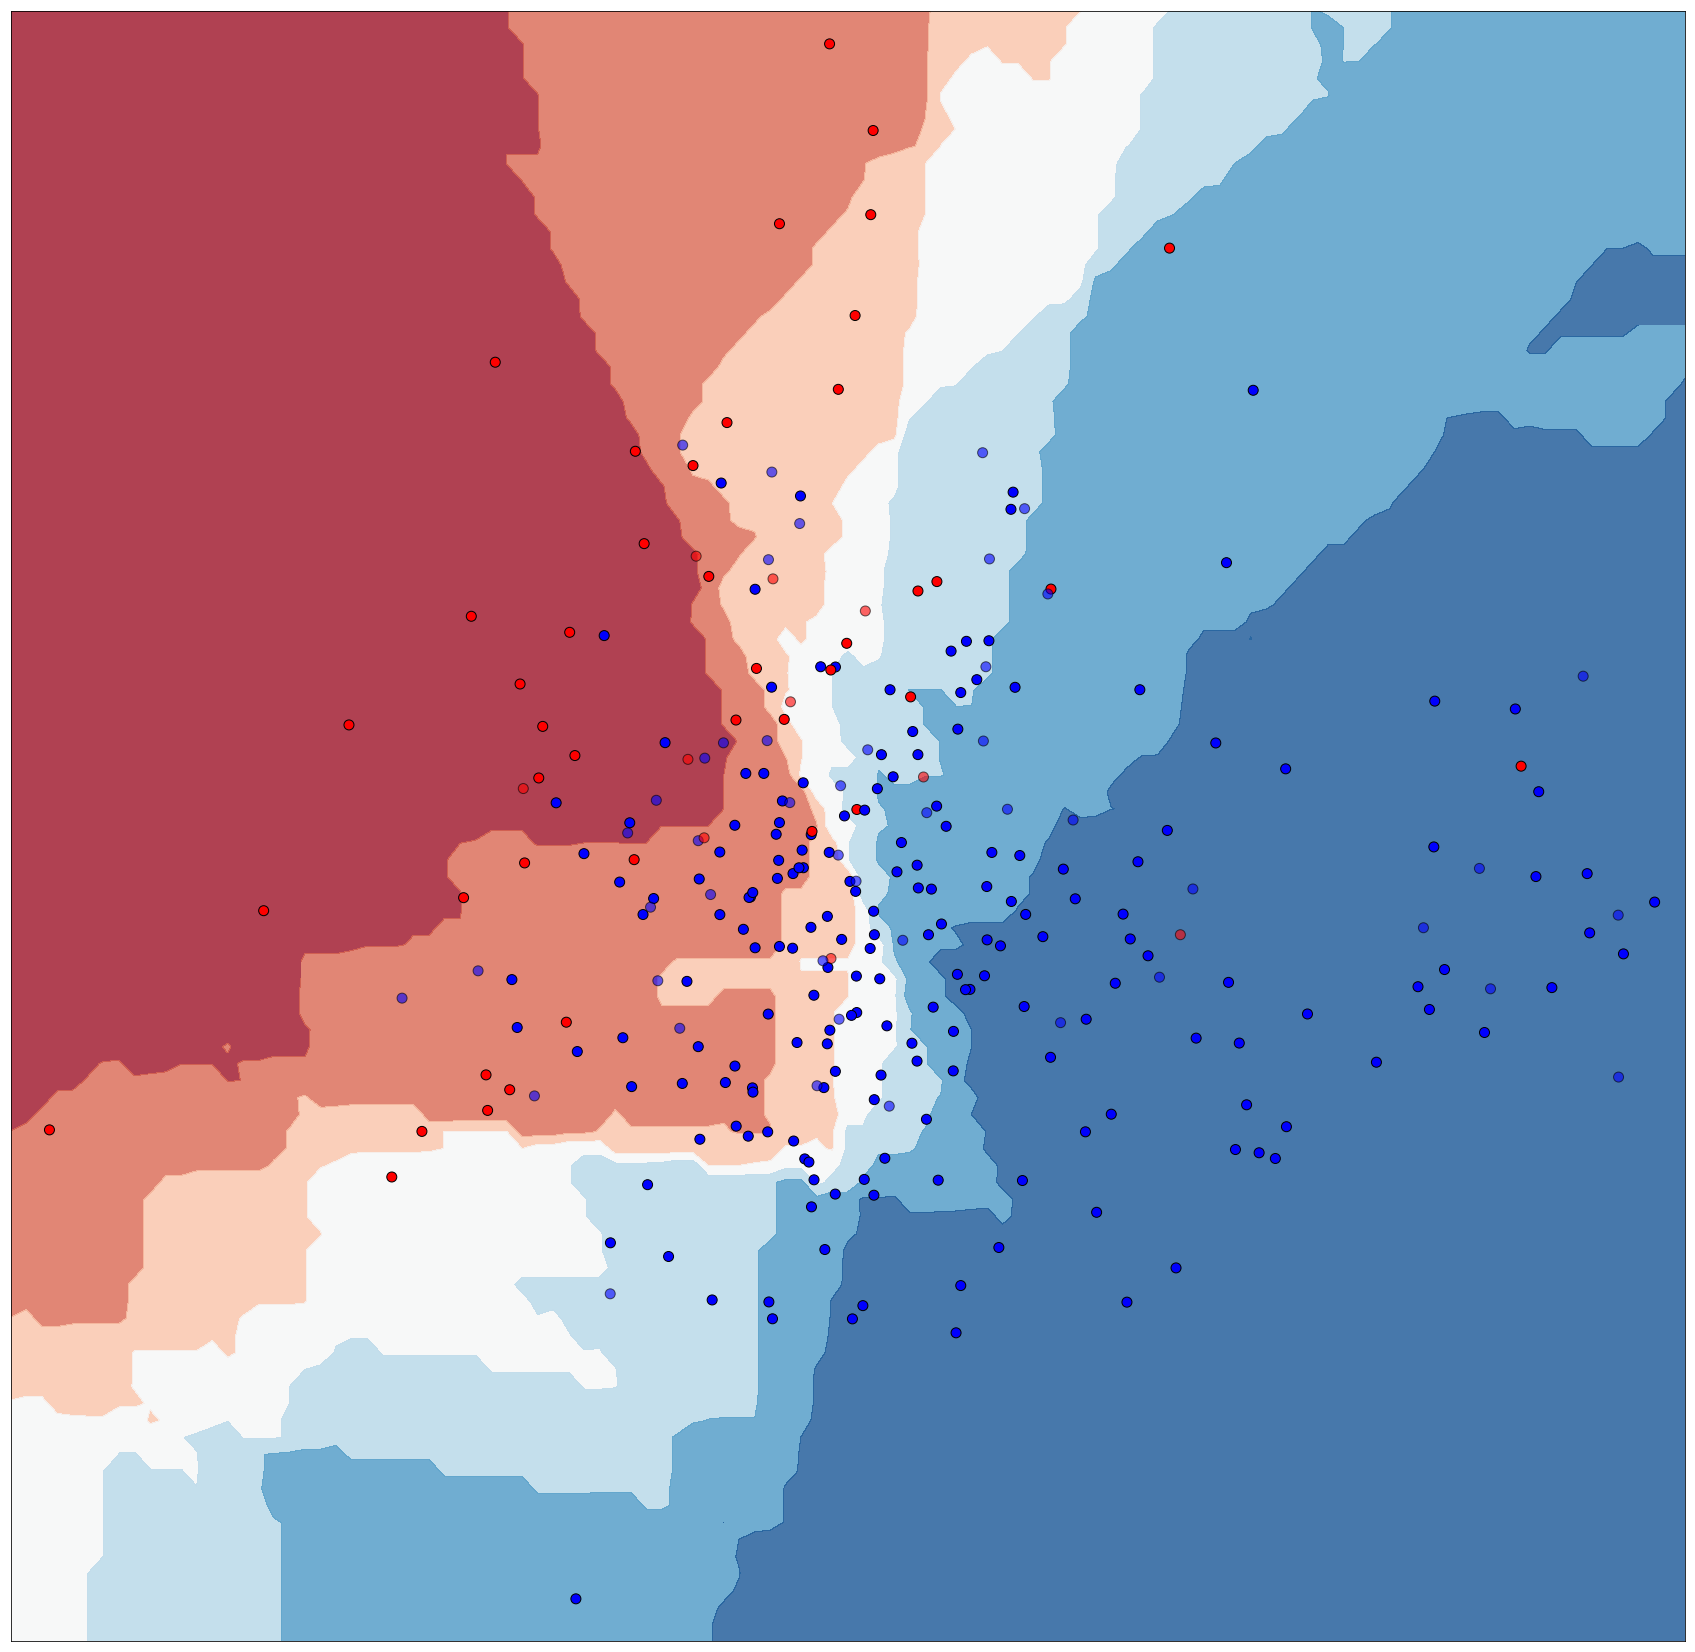

In [568]:
fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)

plotij(2,4,ax,marker_size=100)

plt.savefig('scatterplot3.png',bbox_inches='tight',dpi=300)
plt.show()

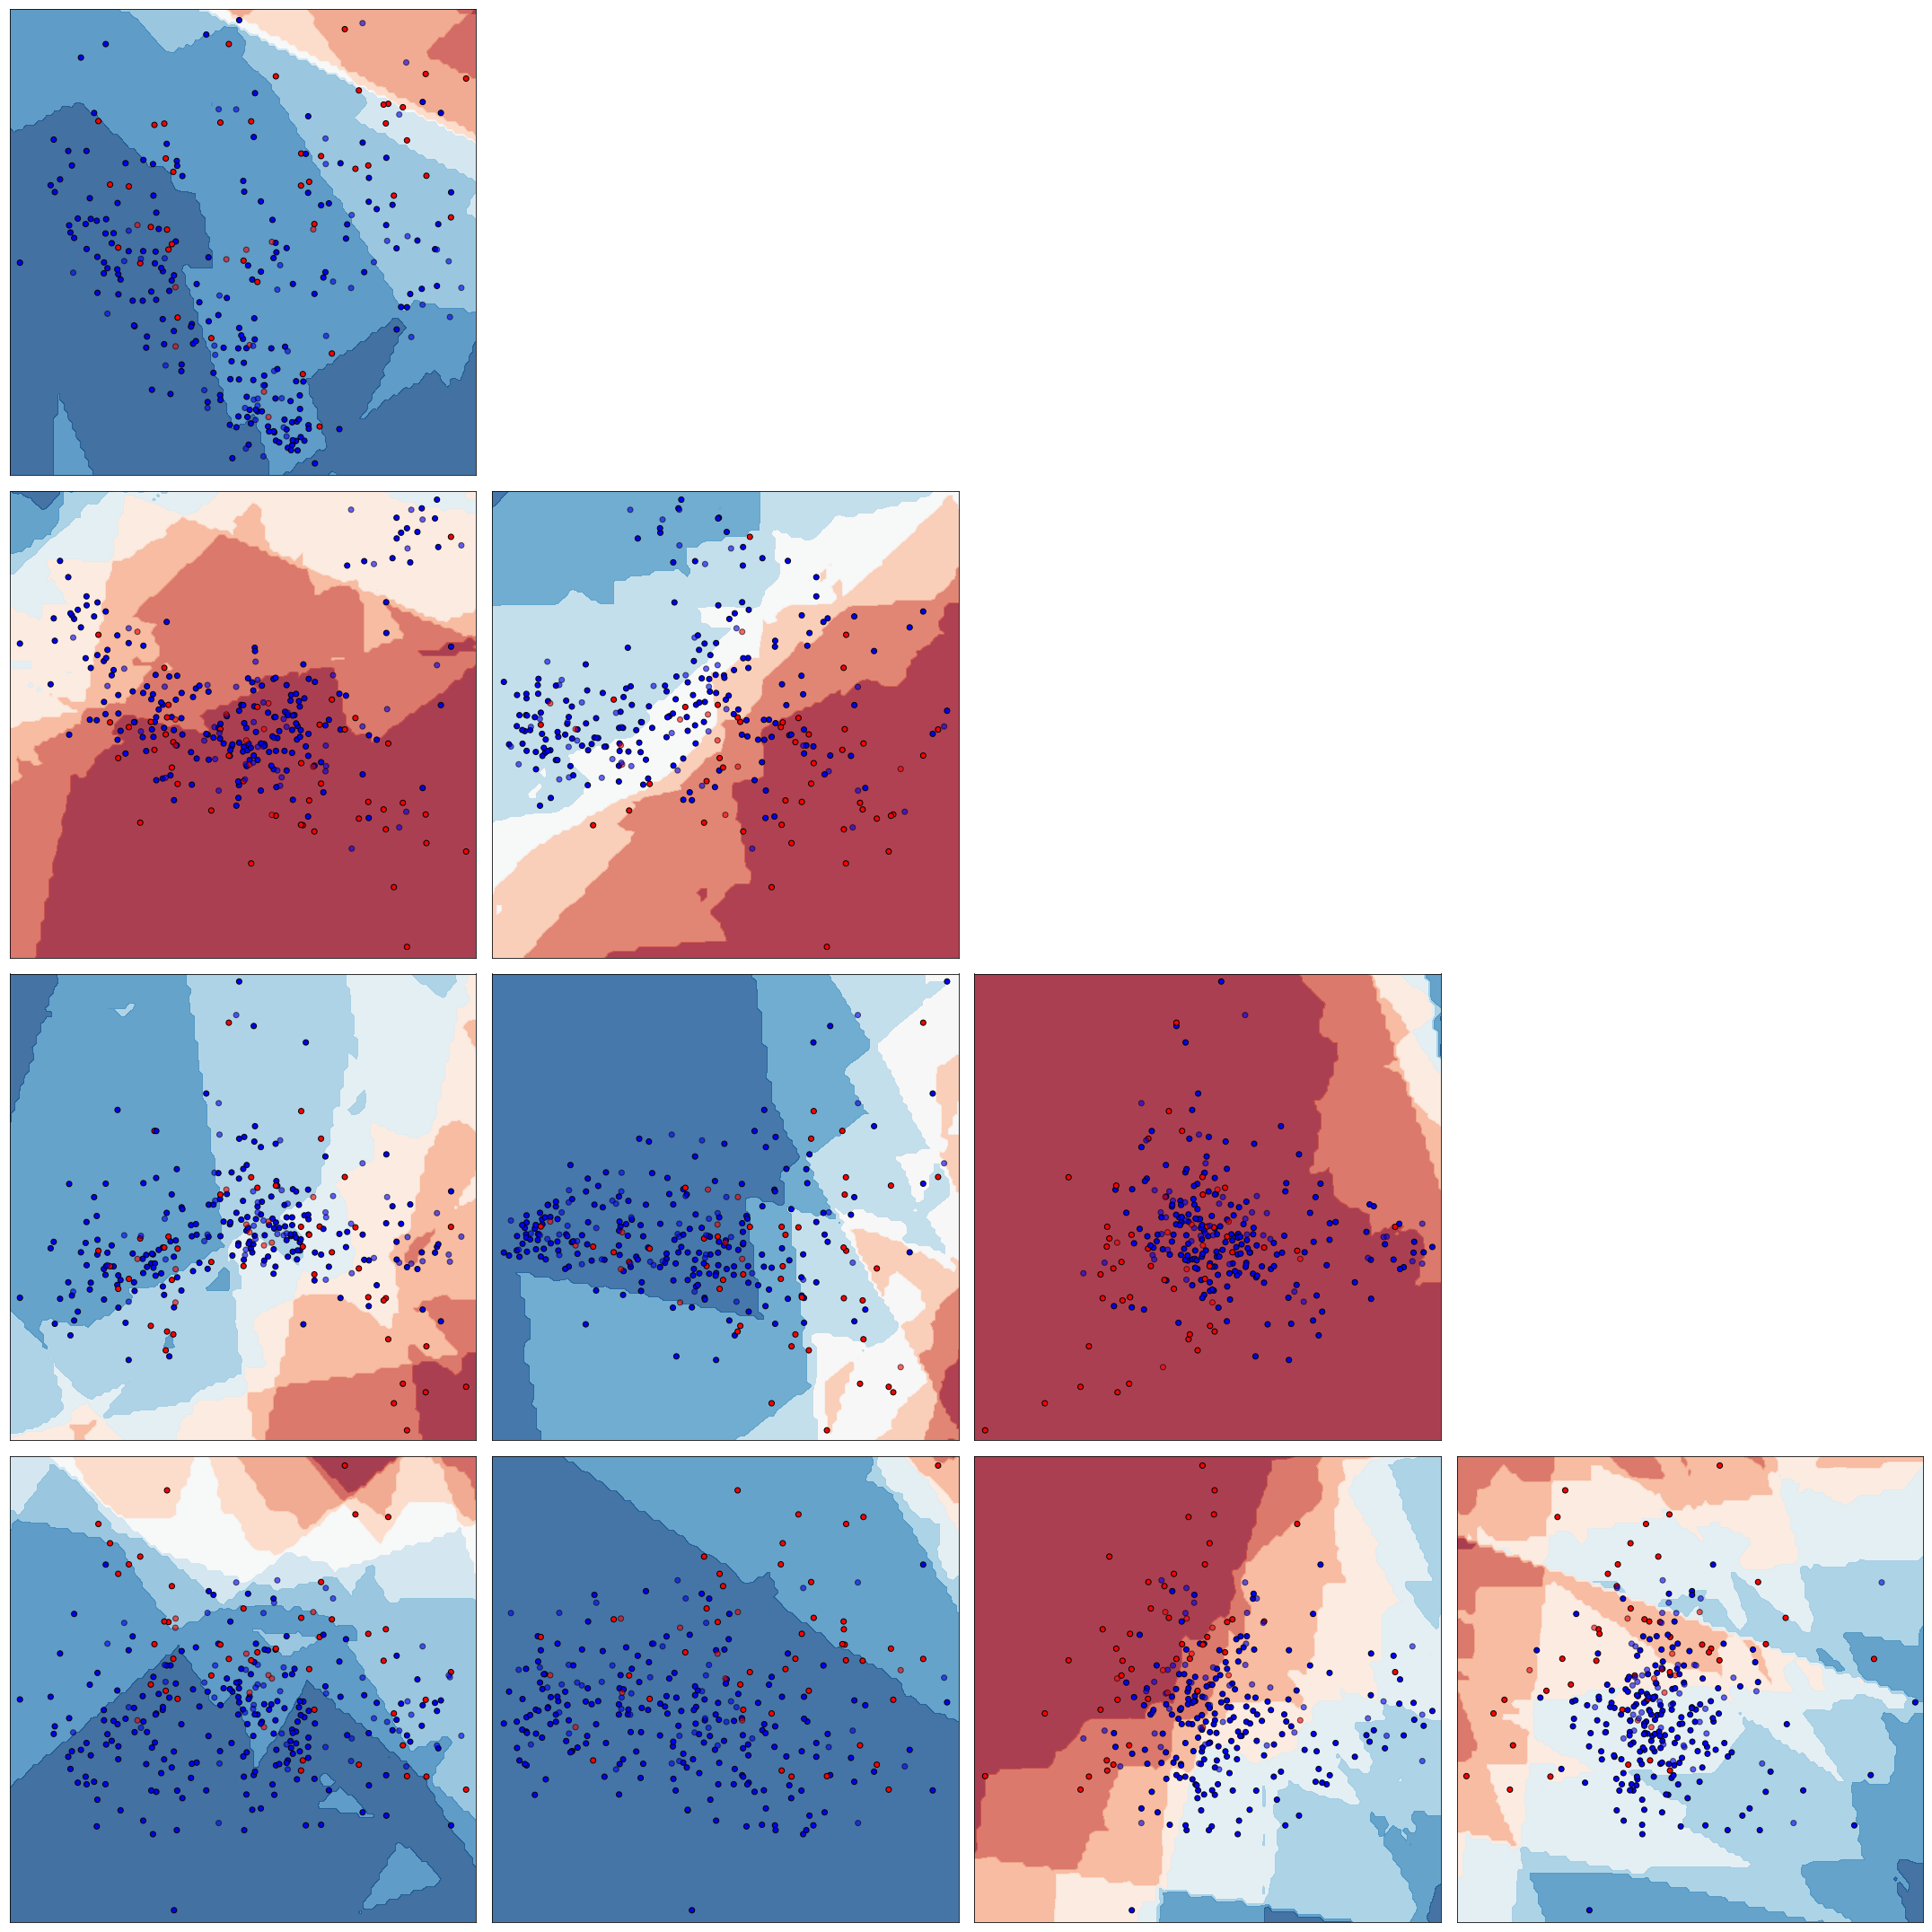

In [520]:
fig = plt.figure(figsize=(30,30))

for i in range(n-1):
    for j in range(i+1,n):
        
        ax = plt.subplot(n-1,n-1,i+1+((n-1)*(j-1)))
        plotij(i,j,ax)
        
plt.tight_layout()
plt.show()

In [499]:
ax.contourf(grid[i][s],grid[j][s],Z[s],cmap=cm,alpha=.8)

In [500]:
ax.scatter(X_valr[:,i],X_valr[:,j],c=Y_val,cmap=cm_bright,edgecolors='k')

In [501]:
ax.scatter(X_testr[:,i],X_testr[:,j],c=Y_test,cmap=cm_bright,edgecolors='k',alpha=0.6)

In [502]:
ax.set_xlim(grid[i].min(),grid[i].max())
ax.set_ylim(grid[j].min(),grid[j].max())

(-11.40696338477731, 10.193036615222614)

In [503]:
ax.set_xticks(())
ax.set_yticks(())

[]

In [504]:
plt.tight_layout()

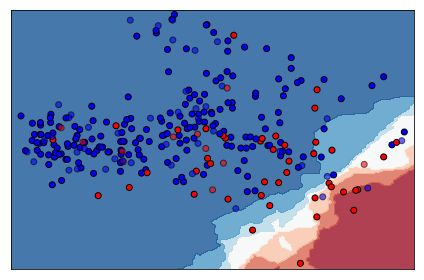

In [505]:
plt.show()

In [31]:
ax = plt.subplot(1,2,1)

In [32]:
ax.scatter(X_valr[:,0],X_valr[:,1],c=Y_val.values,cmap=cm_bright,edgecolors='k')

In [33]:
ax.scatter(X_testr[:, 0], X_testr[:, 1], c=Y_test.values, cmap=cm_bright, alpha=0.6, edgecolors='k')

In [34]:
ax.set_xlim(xx.min(),xx.max())

(-11.477061014757089, 12.322938985242827)

In [35]:
ax.set_ylim(yy.min(),xx.min())

(-8.3190274218787259, -11.477061014757089)

In [36]:
ax.set_xticks(())
ax.set_yticks(())

[]

In [191]:
xx,yy = np.meshgrid(np.arange(x_min,x_max,taille_maille),np.arange(y_min,y_max,taille_maille))

In [377]:
xx, yy, zz = np.meshgrid([50],np.arange(x_min,x_max,taille_maille),np.arange(y_min,y_max,taille_maille))

In [355]:
grid_inv = ACP.inverse_transform(grid_c)

In [356]:
Z = classifieur_model.predict_proba(grid_inv)[:,1]

In [357]:
Z = Z.reshape(grid[0].shape)

In [375]:
mask = [ [(i==j)*np.ones(len(ranges[j])) for j in range(n)] for i in range(n)]